In [1]:
import netCDF4
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import json
from datetime import datetime, timezone, timedelta
import os
import glob
import numpy as np
import pandas as pd
from pyproj import Transformer
import xarray as xr
import xmitgcm as xm
import time
import socket

In [2]:
from datalakes import parse_nc_datalakes_from_folder, datalakes_select_from_depth, datalakes_select_profile, download_data_from_datalakes_dataset
from utils import try_download, open_json, save_json

# Comparison between MITgcm results, simstrat results (from Alplakes) and measurements from Datalakes
This notebook displays :
- the timeserie of the temperature at a given location and depth
- the profile of the temperature at a given location and time
- the heatmap of the profile at a given location

It imports the measure from a netcdf file that can be dowloaded on the datalake platform (https://www.datalakes-eawag.ch/data).
It imports local MITgcm simulation results.

In [3]:
lake_name = "geneva"
sta_name = 'geneva_lexplore'

In [4]:
model = 'new_geneva_200m'
with open('mitgcm/config.json', 'r') as file:
    mitgcm_config = json.load(file)[socket.gethostname()][model]
    
datapath = mitgcm_config['datapath']
gridpath = mitgcm_config['gridpath']
ref_date = mitgcm_config['ref_date']
dt_mitgcm_results = mitgcm_config['dt']

In [5]:
start_date = datetime(2024, 1, 15, 0, 0, 0)
end_date = datetime(2024, 3, 15, 0, 0, 0)

In [6]:
var_to_plot = 'THETA'

In [7]:
with open(os.path.join('config_points.json'), 'r') as file:
    config_points = json.load(file)[sta_name]
    
xc_mitgcm_station = config_points['xc_mitgcm_200m']
yc_mitgcm_station = config_points['yc_mitgcm_200m']

## Import MITgcm results

In [8]:
def convert_ds_to_little_endian(mitgcm_ds):
    mitgcm_ds = mitgcm_ds.astype('<f8')
    mitgcm_ds= mitgcm_ds.assign(Z=mitgcm_ds['Z'].astype('<f8'))
    mitgcm_ds= mitgcm_ds.assign(XC=mitgcm_ds['XC'].astype('<f8'))
    mitgcm_ds= mitgcm_ds.assign(YC=mitgcm_ds['YC'].astype('<f8'))
    mitgcm_ds= mitgcm_ds.assign(XG=mitgcm_ds['XG'].astype('<f8'))
    mitgcm_ds= mitgcm_ds.assign(YG=mitgcm_ds['YG'].astype('<f8'))
    mitgcm_ds= mitgcm_ds.assign(Zp1=mitgcm_ds['Zp1'].astype('<f8'))
    mitgcm_ds= mitgcm_ds.assign(Zu=mitgcm_ds['Zu'].astype('<f8'))
    mitgcm_ds= mitgcm_ds.assign(Zl=mitgcm_ds['Zl'].astype('<f8'))
    
    return mitgcm_ds

In [9]:
ds_to_plot = xm.open_mdsdataset(
                            datapath, 
                            grid_dir=gridpath, 
                            ref_date=ref_date, 
                            prefix='3Dsnaps', 
                            delta_t=dt_mitgcm_results, 
                            endian='>')
ds_to_plot = convert_ds_to_little_endian(ds_to_plot)

In [10]:
ds_001 = xm.open_mdsdataset(
                            "D:\\geneva_calibration\\001", 
                            grid_dir=gridpath, 
                            ref_date=ref_date, 
                            prefix='3Dsnaps', 
                            delta_t=dt_mitgcm_results, 
                            endian='>')
ds_001 = convert_ds_to_little_endian(ds_001)

In [11]:
ds_002 = xm.open_mdsdataset(
                            "D:\\geneva_calibration\\002", 
                            grid_dir=gridpath, 
                            ref_date=ref_date, 
                            prefix='3Dsnaps', 
                            delta_t=dt_mitgcm_results, 
                            endian='>')
ds_002 = convert_ds_to_little_endian(ds_002)

In [12]:
ds_003 = xm.open_mdsdataset(
                            "D:\\geneva_calibration\\003", 
                            grid_dir=gridpath, 
                            ref_date=ref_date, 
                            prefix='3Dsnaps', 
                            delta_t=dt_mitgcm_results, 
                            endian='>')
ds_003 = convert_ds_to_little_endian(ds_003)

In [13]:
ds_004 = xm.open_mdsdataset(
                            "D:\\geneva_calibration\\004", 
                            grid_dir=gridpath, 
                            ref_date=ref_date, 
                            prefix='3Dsnaps', 
                            delta_t=dt_mitgcm_results, 
                            endian='>')
ds_004 = convert_ds_to_little_endian(ds_004)

## Import measure

In [14]:
start_clock = time.time()

xr_measure = download_data_from_datalakes_dataset(667, start_date.replace(tzinfo=timezone.utc), end_date.replace(tzinfo=timezone.utc), "idronaut")

end_clock = time.time()
print(f'Done. Operation took {end_clock - start_clock}s.')

Done. Operation took 65.38305234909058s.


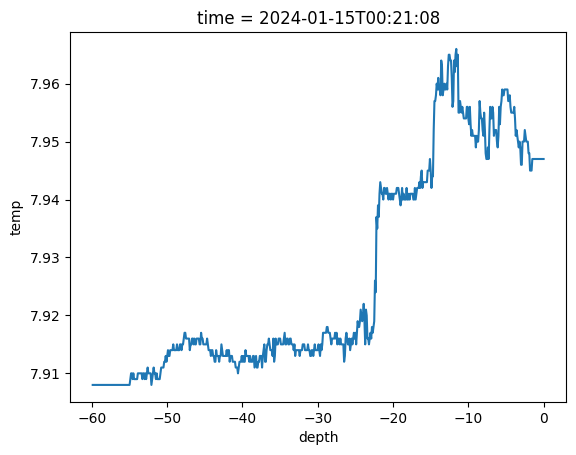

In [15]:
xr_measure['temp'].isel(time=0).plot()

## Import simstrat alplakes 1d 

In [16]:
# Folder containing the JSON files
folder_path = './data/alplakes_1d/'  # Update this to your specific folder path

# Find all JSON files matching the pattern
json_files = glob.glob(os.path.join(folder_path, f'{lake_name}_1d_*.json'))

# Initialize lists to store combined data
all_times = []
all_depths = []
all_temperatures = []

# Loop through each JSON file
for file_path in json_files:
    # Read the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)

    # Extract time data and convert to datetime
    times = [datetime.fromisoformat(t.replace('Z', '+00:00')) for t in data['time']]

    # Extract depth and temperature data
    depths = np.array(data['depth']['data'])
    temperatures = np.array(data['variables']['T']['data'])

    # Append to the combined lists
    all_times.append(times)
    all_depths.append(depths)
    all_temperatures.append(temperatures)
    
# Ensure all depth arrays are consistent
if len(set(len(d) for d in all_depths)) != 1:
    raise ValueError("Depth arrays are not consistent across files.")

# Use the first depth array (assumed consistent across files)
depths = all_depths[0]

# Combine all time and temperature data
all_times = np.concatenate(all_times)
all_times = np.array([dt.replace(tzinfo=None) for dt in all_times])
all_temperatures = np.hstack(all_temperatures)

# Create xarray dataset
simstrat_data = xr.Dataset(
    {
        'temperature': (['depth', 'time'], np.stack(all_temperatures))
    },
    coords={
        'time': all_times,
        'depth': depths
    }
)

## Plot timeseries temperature at depth "depth_simu"

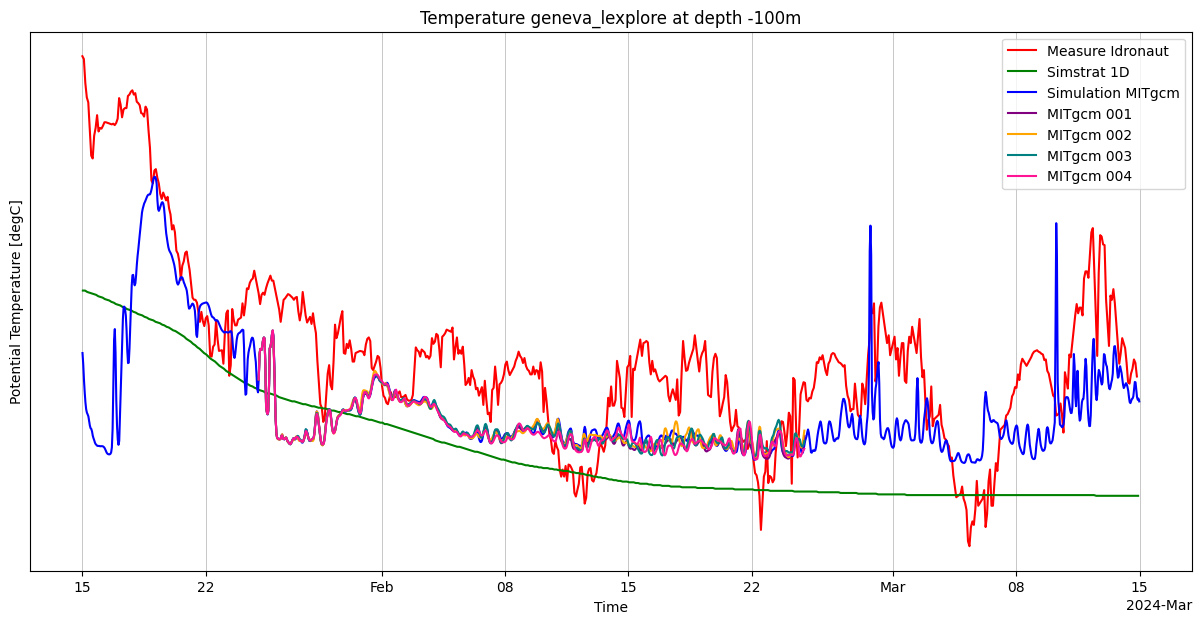

In [24]:
depth_plot=-100 # Value should be negative !!

fig, ax = plt.subplots(1,1,figsize=(15, 7))

if xr_measure is not None:
    meas_selected = xr_measure['temp'].sel(depth=depth_plot, method='nearest').sel(time=slice(start_date,end_date))
    meas_selected.plot(label=f'Measure Idronaut', color='r')

simstrat_data['temperature'].sel(depth=-depth_plot, method='nearest').sel(time=slice(start_date,end_date)).plot(label=f'Simstrat 1D', color='g')

sim_selected=ds_to_plot[var_to_plot].sel(Z=depth_plot, XC=xc_mitgcm_station, YC=yc_mitgcm_station, method='nearest').sel(time=slice(start_date, end_date))
sim_selected.plot(label='Simulation MITgcm', color='b')

ds_001[var_to_plot].sel(Z=depth_plot, XC=xc_mitgcm_station, YC=yc_mitgcm_station, method='nearest').sel(time=slice(start_date, end_date)).plot(label='MITgcm 001', color='purple')
ds_002[var_to_plot].sel(Z=depth_plot, XC=xc_mitgcm_station, YC=yc_mitgcm_station, method='nearest').sel(time=slice(start_date, end_date)).plot(label='MITgcm 002', color='orange')
ds_003[var_to_plot].sel(Z=depth_plot, XC=xc_mitgcm_station, YC=yc_mitgcm_station, method='nearest').sel(time=slice(start_date, end_date)).plot(label='MITgcm 003', color='teal')
ds_004[var_to_plot].sel(Z=depth_plot, XC=xc_mitgcm_station, YC=yc_mitgcm_station, method='nearest').sel(time=slice(start_date, end_date)).plot(label='MITgcm 004', color='deeppink')

plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.legend()
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
plt.title(f"Temperature {sta_name} at depth {depth_plot}m")

plt.savefig(rf"output_plots\{lake_name}\all_200m_{depth_plot}m.png")

# Profile

In [18]:
date_plot_profil = datetime(2024,2,17,12,0,0)
date_plot_profil_str = date_plot_profil.strftime('%Y%m%d%H%M')

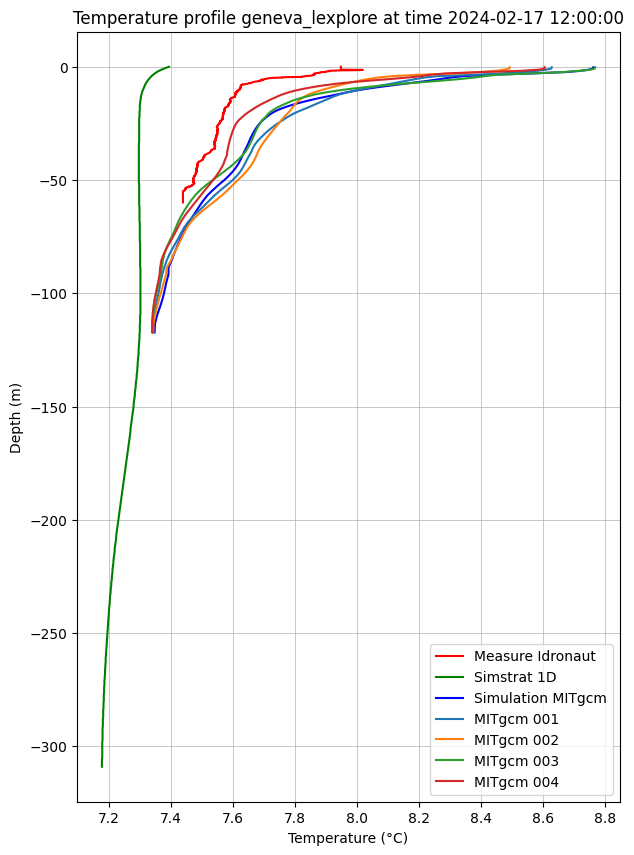

In [19]:
fig = plt.figure(figsize=(7, 10))

meas_profile = xr_measure['temp'].sel(time=date_plot_profil, method='nearest')
plt.plot(meas_profile.values, meas_profile.depth.values, label=f'Measure Idronaut', color='r')

# Convert Simstrat depth to negative and plot
simstrat_depth_negative = -simstrat_data['depth'].values  # Convert to negative NumPy array
simstrat_temperature = simstrat_data['temperature'].sel(time=date_plot_profil, method='nearest')
plt.plot(simstrat_temperature.values, simstrat_depth_negative, label='Simstrat 1D', color='g')


profile_to_plot = ds_to_plot['THETA'].sel(XC=xc_mitgcm_station, YC=yc_mitgcm_station, time=date_plot_profil, method='nearest')
profile_to_plot.where(profile_to_plot != 0, np.nan).plot(y='Z', label='Simulation MITgcm', color='b')

ds_001[var_to_plot].sel(XC=xc_mitgcm_station, YC=yc_mitgcm_station, time=date_plot_profil, method='nearest').where(profile_to_plot != 0, np.nan).plot(y='Z',label='MITgcm 001')
ds_002[var_to_plot].sel(XC=xc_mitgcm_station, YC=yc_mitgcm_station, time=date_plot_profil, method='nearest').where(profile_to_plot != 0, np.nan).plot(y='Z',label='MITgcm 002')
ds_003[var_to_plot].sel(XC=xc_mitgcm_station, YC=yc_mitgcm_station, time=date_plot_profil, method='nearest').where(profile_to_plot != 0, np.nan).plot(y='Z',label='MITgcm 003')
ds_004[var_to_plot].sel(XC=xc_mitgcm_station, YC=yc_mitgcm_station, time=date_plot_profil, method='nearest').where(profile_to_plot != 0, np.nan).plot(y='Z',label='MITgcm 004')

plt.title(f"Temperature profile {sta_name} at time {date_plot_profil}")
plt.grid(True, which='both', linestyle='-', linewidth=0.5)
plt.ylabel('Depth (m)')
plt.xlabel('Temperature (°C)')
plt.legend()
plt.savefig(rf"output_plots\{lake_name}\profile_{date_plot_profil.date()}.png")